In [1]:
# Simple LSTM regression
# 2017-03-16 jkang
# Python3.5
# Tensorflow1.0.1
#
# input: one sinewave
# output: one sinewave (shifted input)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Input, Ouput dataset
duration = 10  # sec
srate = 100  # Hz
freq = .5  # Hz
amplitude = np.random.random(1) * 10
t = np.linspace(0, duration, duration * srate + 1)
sin = np.sin(2 * np.pi * freq * t) * amplitude
shift = int(srate/freq*1/4) # 1/4 phase shift to make input & output orthogonal
sin_in = sin[:-shift]
sin_out = sin[shift:]  # shifting

# Hyper-Parameters
learning_rate = 0.01
max_iter = 20

# Network Parameters
n_input_dim = 1
n_input_len = len(sin_in)
n_output_len = len(sin_out)
n_hidden = 100
n_output_dim = 1

# TensorFlow graph
# (batch_size) x (time_step) x (input_dimension)
x_data = tf.placeholder(tf.float32, [1, n_input_len, n_input_dim])
# (batch_size) x (time_step) x (output_dimension)
y_data = tf.placeholder(tf.float32, [1, n_output_len, n_output_dim])

# Parameters
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_output_dim]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_output_dim]))
}

In [3]:
def RNN(x, weights, biases):
    cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0) # Make LSTMCell
    outputs, states = tf.nn.dynamic_rnn(cell, x, time_major=False, dtype=tf.float32)
    '''
    **Notes on tf.nn.dynamic_rnn**

    - 'x' can have shape (batch)x(time)x(input_dim), if time_major=Flase or 
                         (time)x(batch)x(input_dim), if time_major=True
    - 'outputs' can have the same shape as 'x'
                         (batch)x(time)x(input_dim), if time_major=Flase or 
                         (time)x(batch)x(input_dim), if time_major=True
    - 'states' is the final state, determined by batch and hidden_dim
    '''
    
    # outputs[-1] is outputs for the last example in the mini-batch
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x_data, weights, biases)
cost = tf.reduce_mean(tf.squared_difference(pred, y_data))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [4]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step <= max_iter:
        x_train = sin_in.reshape((1, n_input_len, n_input_dim))
        y_train = sin_out.reshape((1, n_output_len, n_output_dim))
        c, _ = sess.run([cost, optimizer], feed_dict={x_data: x_train, y_data: y_train})
        print('Epoch =', str(step), '/', str(max_iter),
              'Cost = ', '{:.5f}'.format(c))
        step += 1

    # Test
    pred_out = sess.run(pred, feed_dict={x_data: x_train})

Epoch = 1 / 20 Cost =  9.23477
Epoch = 2 / 20 Cost =  43.47899
Epoch = 3 / 20 Cost =  3.84097
Epoch = 4 / 20 Cost =  7.45278
Epoch = 5 / 20 Cost =  3.88488
Epoch = 6 / 20 Cost =  3.89205
Epoch = 7 / 20 Cost =  3.89473
Epoch = 8 / 20 Cost =  2.82488
Epoch = 9 / 20 Cost =  1.90995
Epoch = 10 / 20 Cost =  1.65777
Epoch = 11 / 20 Cost =  1.56339
Epoch = 12 / 20 Cost =  0.74331
Epoch = 13 / 20 Cost =  1.48065
Epoch = 14 / 20 Cost =  0.35134
Epoch = 15 / 20 Cost =  0.48582
Epoch = 16 / 20 Cost =  0.71771
Epoch = 17 / 20 Cost =  0.66952
Epoch = 18 / 20 Cost =  0.53148
Epoch = 19 / 20 Cost =  0.52858
Epoch = 20 / 20 Cost =  0.60734


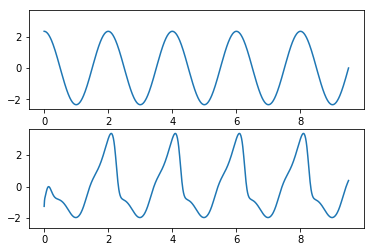

In [5]:
# Plot
f, axes = plt.subplots(2, sharey=True)
axes[0].plot(t[:-shift], sin_out)
axes[1].plot(t[:-shift], pred_out)
plt.show()

## Thoughts

* Compared to vanilla RNN ([predict_sinewave_using_RNN](https://github.com/jaekookang/useful_bits/blob/master/Machine_Learning/RNN_LSTM/predict_sinewave/rnn_sinewave_one.ipynb)), LSTM learns sinewave better (smaller cost) and quickly (less epoch)